In [125]:
from pettingzoo.classic import connect_four_v3

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

In [127]:
env = connect_four_v3.env(render_mode="rgb_array")

# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [128]:
# The agents are loacted in the dqn_utils file 

# Running a game


The following function runs a full game between the two agents. 

In [129]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

In [130]:
# agent0 = RandomPlayer()
# agent1 = PlayLeftmostLegal()

# play_game(env, agent0, agent1, display=True)

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [155]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [148]:
def eval_against_policy(env, agent, policy, n_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(n_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

# Training an agent 

In [149]:
def training_dashboard(eval_before_training, eval_after_training, losses, all_rewards, episodes_length):
    fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    gs0 = fig.add_gridspec(nrows=2, ncols=1)

    gs00 = gs0[0].subgridspec(1, 2)
    gs01 = gs0[1].subgridspec(1, 3)

    ax1 = fig.add_subplot(gs00[0:1])
    ax1.hist(eval_before_training)
    ax1.set_title("Performances before training")
    ax2 = fig.add_subplot(gs00[1:2])
    ax2.hist(eval_after_training)
    ax2.set_title("Performances after training")
    ax3 = fig.add_subplot(gs01[0:1])
    ax3.plot(losses)
    ax3.set_title("Loss evolution")
    ax3.set_yscale('log')
    ax4 = fig.add_subplot(gs01[1:2])
    ax4.plot(all_rewards)
    ax4.set_title("Rewards evolution")
    ax5 = fig.add_subplot(gs01[2:3])
    ax5.plot(episodes_length)
    ax5.set_title("Episode length evolution")

    plt.show()


In [150]:
def train_player_0(env, player_0, player_1, n_episodes, first_player = True, eval_every=100, reward_threshold=0.9, early_stopping_insistance=3):
    
    if first_player : 
        agents = [player_0, player_1]
    else : 
        agents = [player_1, player_0]
    losses = []
    all_rewards = []
    episodes_length = []
    
    for ep in tqdm(range(n_episodes), desc="Train"):
        done = False
        env.reset()
        length_episode = 0
        agent_0_previous_state = None
        agent_0_previous_reward = None
        agent_1_previous_reward = None
        almost_done = False
        while not done:
            length_episode += 1
            for agent in agents:
                state_I_have_to_play_in, _, _, _, _ = env.last()
                
                # almost done is True when player 1 has won, in which case we just need to compute its last move in the memory
                # else we obviously play
                if not almost_done : 
                    epsilon = 0 if agent == player_1 else None
                    action = agent.get_action(state_I_have_to_play_in, epsilon=epsilon)
                    env.step(action)
                    # beware as state_after_I_played is now from the other's agent point of view
                    state_after_I_played, reward, terminated, truncated, info = env.last()
                    done = terminated or truncated
                else :
                    # swap point of view of players, because it is frozen on player 1 pov since they are the winner
                    state_I_have_to_play_in["observation"][:,:, [0, 1]] = state_I_have_to_play_in["observation"][:,:, [1, 0]]

                if agent == player_0 :
                    # we update the episode that happened a turn before as we need to see how the other agent will react to our move
                    if agent_0_previous_state is not None : # when the episode begins
                        loss_val = agent.update(agent_0_previous_state, agent_0_previous_action, agent_0_previous_reward - agent_1_previous_reward, agent_0_terminated, state_I_have_to_play_in)
                        if loss_val is not None : 
                            losses.append(loss_val)
                    agent_0_previous_state = state_I_have_to_play_in
                    agent_0_previous_reward = reward
                    agent_0_previous_action = action
                    agent_0_terminated = terminated
                if agent == player_1 : 
                    agent_1_previous_reward = reward
                if done and agent == player_1 : 
                    almost_done = True
                if done and agent == player_0 : 
                    break 
        
        episodes_length.append(length_episode)
        
        if ep%eval_every == 0:
            # print("[Train] Evaluating the DQN Agent.")
            rewards = eval_against_policy(env, player_0, player_1, n_episodes=30, first_player=first_player)
            all_rewards.append(np.mean(rewards))
            # print(f"Mean reward is: {np.mean(rewards)}")
            # early stopping
            if np.mean(rewards) >= reward_threshold:
                # the threshold needs to be reached several time for the training to stop
                early_stopping_insistance -= 1
                if early_stopping_insistance == 0  : 
                    break
            
                
    return losses, all_rewards, episodes_length

# Some training experiments

### DQN Agent vs Random Agent, DQN agent playing first

In [135]:
import dqn_utils
import importlib
importlib.reload(dqn_utils)  # to reload easily when I modify the agent's code :)

<module 'dqn_utils' from '/Users/sachamuller/Documents/Scolaire/5-CentraleSupelec/3A/7-SM11/RL/connect4/dqn_utils.py'>

In [106]:
gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-1

DQN_agent = dqn_utils.DQN_Skeleton(
        action_space_size=7, # number of columns
        observation_space_size = 6*7,  # nb_rows, nb_columns
        gamma=gamma,
        batch_size=batch_size,
        buffer_capacity=buffer_capacity,
        update_target_every=update_target_every,
        epsilon_start=epsilon_start,
        decrease_epsilon_factor=decrease_epsilon_factor,
        epsilon_min=epsilon_min,
        learning_rate=learning_rate,
        env=env,
    )

random_agent = dqn_utils.RandomAgent()

first_player = True

losses = []
all_rewards = []
episodes_length = []

In [112]:
eval_before_training = eval_against_policy(env, DQN_agent, random_agent, n_episodes=1000, first_player=first_player)

In [85]:
current_losses, current_all_rewards, current_episodes_length =  train_player_0(env, DQN_agent, random_agent, 10000, first_player=first_player, early_stopping_insistance=15)
losses += current_losses
all_rewards += current_all_rewards
episodes_length += current_episodes_length

Train: 100%|██████████| 10000/10000 [08:49<00:00, 18.90it/s]


In [86]:
eval_after_training = eval_against_policy(env, DQN_agent, random_agent, n_episodes=1000, first_player=first_player)

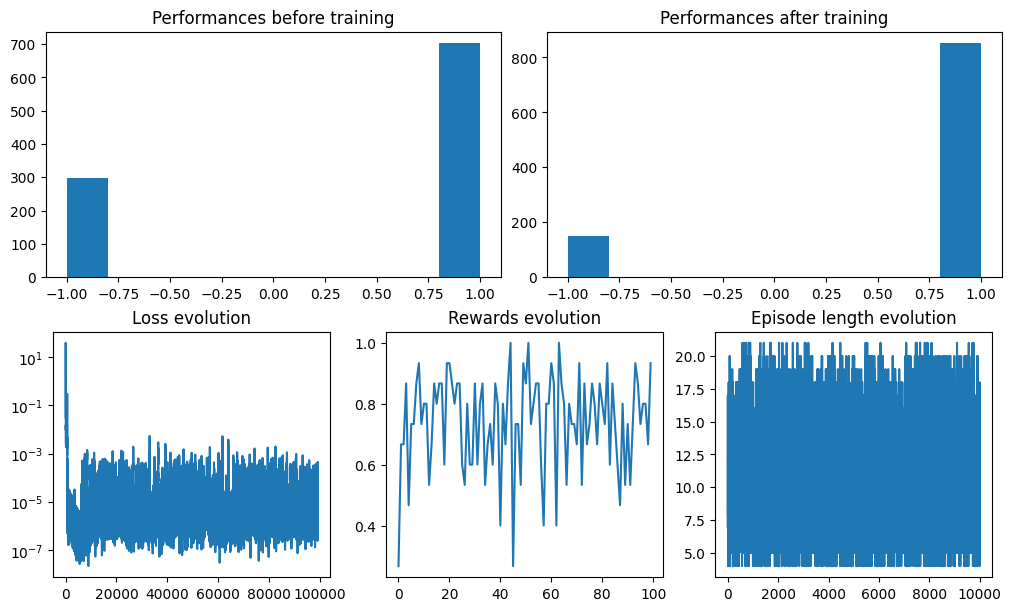

In [87]:
training_dashboard(eval_before_training, eval_after_training, losses, all_rewards, episodes_length)

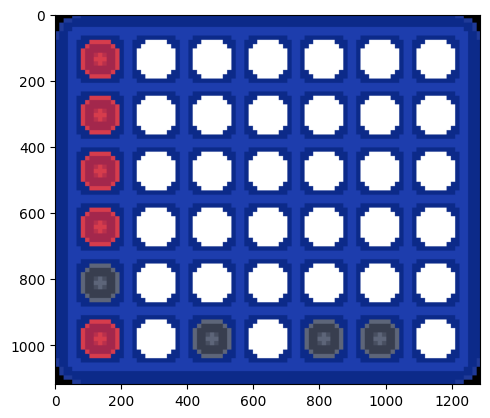

Player 0: DQN Agent won
[[ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 1  0 -1  0 -1 -1  0]]


In [88]:
if first_player : 
    play_game(env, DQN_agent, random_agent, display=True)
else : 
    play_game(env, random_agent, DQN_agent, display=True)

### DQN Agent vs Left most agent

In [11]:
import dqn_utils
import importlib
importlib.reload(dqn_utils)  # to reload easily when I modify the agent's code :)

<module 'dqn_utils' from '/Users/sachamuller/Documents/Scolaire/5-CentraleSupelec/3A/7-SM11/RL/connect4/dqn_utils.py'>

In [24]:
gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 10
epsilon_min = 0.05

learning_rate = 1e-1

DQN_agent = dqn_utils.DQN_Skeleton(
        action_space_size=7, # number of columns
        observation_space_size = 6*7,  # nb_rows, nb_columns
        gamma=gamma,
        batch_size=batch_size,
        buffer_capacity=buffer_capacity,
        update_target_every=update_target_every,
        epsilon_start=epsilon_start,
        decrease_epsilon_factor=decrease_epsilon_factor,
        epsilon_min=epsilon_min,
        learning_rate=learning_rate,
        env=env,
    )

left_agent = dqn_utils.PlayLeftmostLegal()

first_player=False

losses = []
all_rewards = []
episodes_length = []

In [25]:
eval_before_training = eval_against_policy(env, DQN_agent, left_agent, n_episodes=1000, first_player=first_player)

In [26]:
current_losses, current_all_rewards, current_episodes_length = train_player_0(env, DQN_agent, left_agent, 1000, first_player=first_player)
losses += current_losses
all_rewards += current_all_rewards
episodes_length += current_episodes_length

Train:  50%|█████     | 500/1000 [00:07<00:07, 63.08it/s]


In [27]:
eval_after_training = eval_against_policy(env, DQN_agent, left_agent, n_episodes=1000, first_player=first_player)

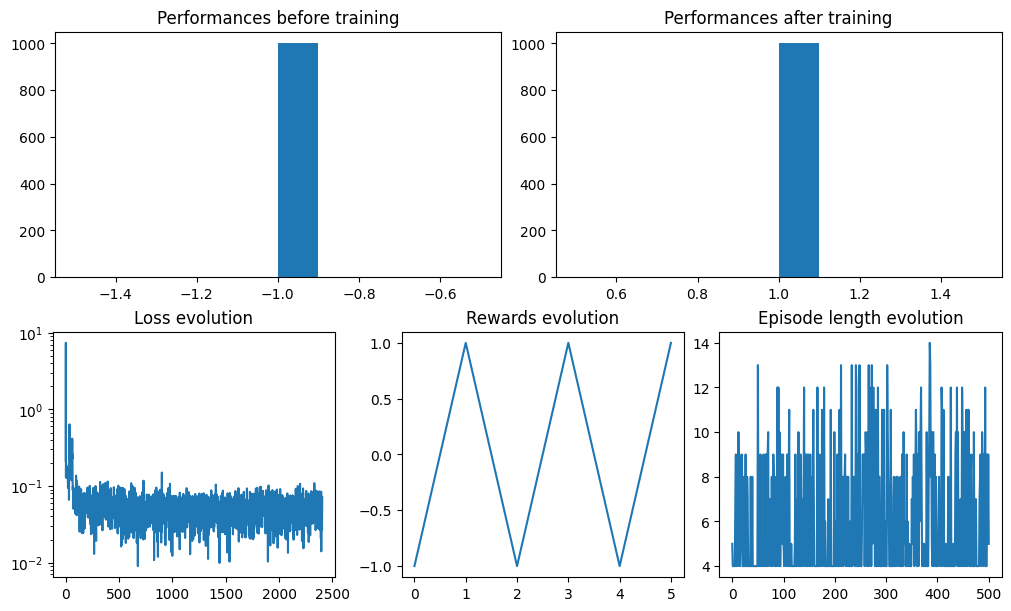

In [28]:
training_dashboard(eval_before_training, eval_after_training, losses, all_rewards, episodes_length)

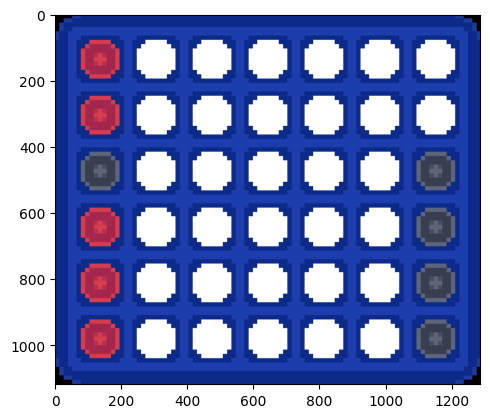

Player 1: DQN Agent won
[[-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  1]
 [-1  0  0  0  0  0  1]
 [-1  0  0  0  0  0  1]
 [-1  0  0  0  0  0  1]]


In [29]:
if first_player : 
    play_game(env, DQN_agent, left_agent, display=True)
else : 
    play_game(env, left_agent, DQN_agent, display=True)

### Training 2 DQNs against one another

In [151]:
import dqn_utils
import importlib
importlib.reload(dqn_utils)  # to reload easily when I modify the agent's code :)

<module 'dqn_utils' from '/Users/sachamuller/Documents/Scolaire/5-CentraleSupelec/3A/7-SM11/RL/connect4/dqn_utils.py'>

In [159]:
gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 100
epsilon_min = 0.05

learning_rate = 1e-1

DQN_agent_0 = dqn_utils.DQN_Skeleton(
        action_space_size=7, # number of columns
        observation_space_size = 6*7,  # nb_rows, nb_columns
        gamma=gamma,
        batch_size=batch_size,
        buffer_capacity=buffer_capacity,
        update_target_every=update_target_every,
        epsilon_start=epsilon_start,
        decrease_epsilon_factor=decrease_epsilon_factor,
        epsilon_min=epsilon_min,
        learning_rate=learning_rate,
        env=env,
        name="DQN 0"
    )

DQN_agent_1 = dqn_utils.DQN_Skeleton(
        action_space_size=7, # number of columns
        observation_space_size = 6*7,  # nb_rows, nb_columns
        gamma=gamma,
        batch_size=batch_size,
        buffer_capacity=buffer_capacity,
        update_target_every=update_target_every,
        epsilon_start=epsilon_start,
        decrease_epsilon_factor=decrease_epsilon_factor,
        epsilon_min=epsilon_min,
        learning_rate=learning_rate,
        env=env,
        name="DQN 1"
    )

losses_0 = []
losses_1 = []
all_rewards_0 = []
all_rewards_1 = []
episodes_length_0 = []
episodes_length_1 = []

player_0_first = True

In [160]:
eval_before_training_0 = eval_against_policy(env, DQN_agent_0, DQN_agent_1, n_episodes=1000, first_player=player_0_first)
eval_before_training_1 = eval_against_policy(env, DQN_agent_1, DQN_agent_0, n_episodes=1000, first_player=(not player_0_first))

In [161]:
switch_first_player = False
length_each_train = 500
nb_turns = 4

for _ in range(nb_turns) : 

    current_losses, current_all_rewards, current_episodes_length = train_player_0(env, DQN_agent_0, DQN_agent_1, length_each_train, first_player=player_0_first)
    losses_0 += current_losses
    all_rewards_0 += current_all_rewards
    episodes_length_0 += current_episodes_length

    current_losses, current_all_rewards, current_episodes_length = train_player_0(env, DQN_agent_1, DQN_agent_0, length_each_train, first_player=(not player_0_first))
    losses_1 += current_losses
    all_rewards_1 += current_all_rewards
    episodes_length_1 += current_episodes_length

    if switch_first_player : 
        player_0_first = not player_0_first

Train: 100%|██████████| 500/500 [00:13<00:00, 35.84it/s]


In [164]:
eval_after_training_0 = eval_against_policy(env, DQN_agent_0, DQN_agent_1, n_episodes=1000, first_player=player_0_first)
eval_after_training_1 = eval_against_policy(env, DQN_agent_1, DQN_agent_0, n_episodes=1000, first_player=(not player_0_first))

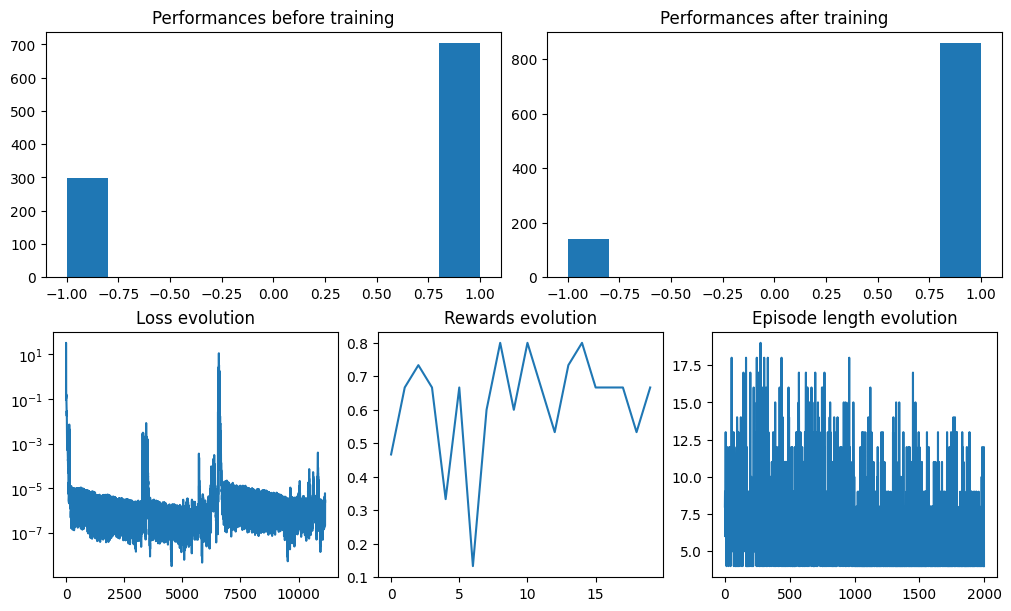

In [165]:
training_dashboard(eval_before_training_0, eval_after_training_0, losses_0, all_rewards_0, episodes_length_0)

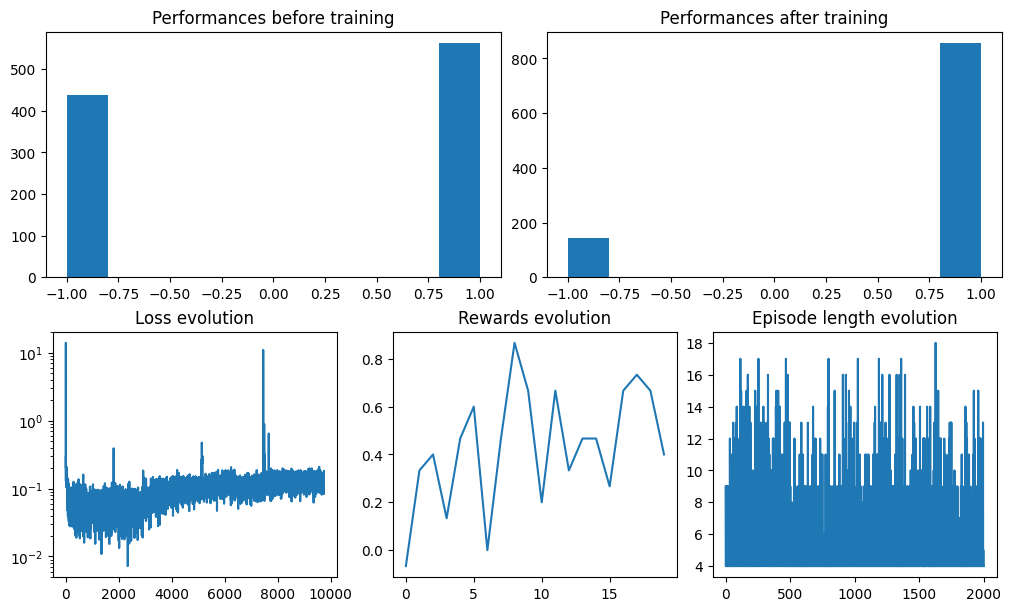

In [166]:
training_dashboard(eval_before_training_1, eval_after_training_1, losses_1, all_rewards_1, episodes_length_1)

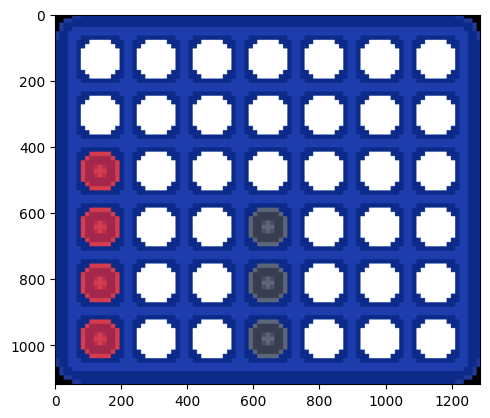

Player 0: DQN 0 won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0 -1  0  0  0]
 [ 1  0  0 -1  0  0  0]
 [ 1  0  0 -1  0  0  0]]


In [167]:
test_with_player_0_first = True
if test_with_player_0_first : 
    play_game(env, DQN_agent_0, DQN_agent_1, display=True)
else : 
    play_game(env, DQN_agent_1, DQN_agent_0, display=True)